In [3]:
!pip install streamlit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import streamlit as st

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load TripAdvisor Hotel Reviews dataset
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [5]:
# Check for missing values
df.dropna(subset=['Review', 'Rating'], inplace=True)

In [6]:
# Convert ratings into sentiment labels
def get_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Rating'].apply(get_sentiment)

<ipython-input-7-402100f7861a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm')


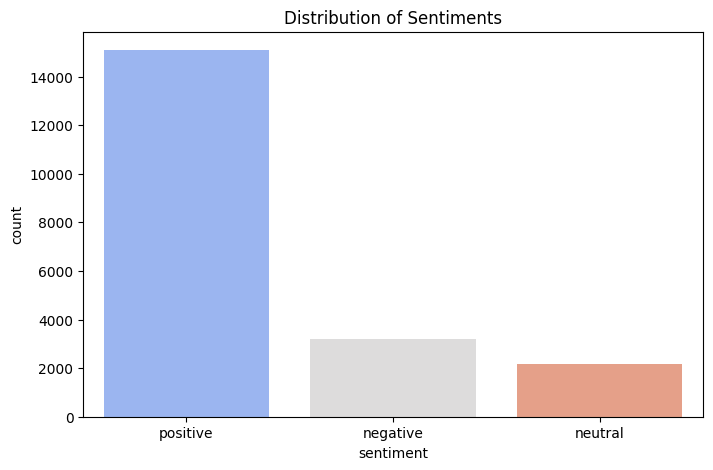

In [7]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title('Distribution of Sentiments')
plt.show()

In [8]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_reviews'] = df['Review'].apply(preprocess_text)


In [9]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_reviews'])
y = df['sentiment']

In [10]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [12]:
# Train Logistic Regression with Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
log_reg = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
log_reg.fit(X_train_res, y_train_res)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

Logistic Regression Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.78      0.76       643
     neutral       0.33      0.39      0.36       437
    positive       0.93      0.89      0.91      3019

    accuracy                           0.82      4099
   macro avg       0.66      0.69      0.67      4099
weighted avg       0.83      0.82      0.82      4099



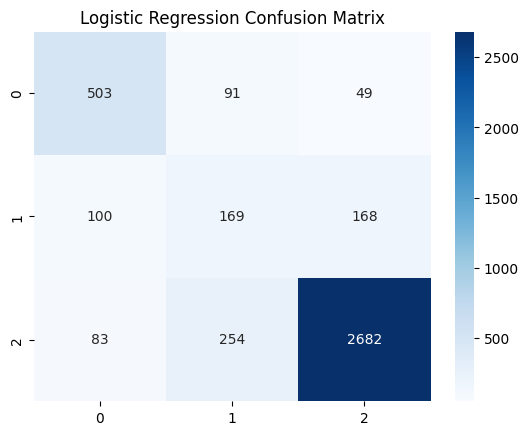

In [13]:
# Evaluate Logistic Regression
y_pred_log = log_reg.best_estimator_.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

#Create a LabelEncoder object
label_encoder = LabelEncoder()

#Fit and transform the target variable
y_train_res = label_encoder.fit_transform(y_train_res)
y_test = label_encoder.transform(y_test)

# Train XGBoost Model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='mlogloss')
xgb.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70       643
           1       0.32      0.26      0.29       437
           2       0.87      0.92      0.89      3019

    accuracy                           0.81      4099
   macro avg       0.64      0.61      0.63      4099
weighted avg       0.79      0.81      0.80      4099



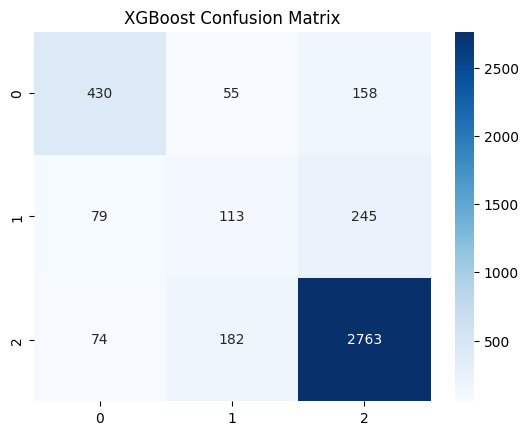

In [19]:
# Evaluate XGBoost
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [20]:
# Compare Models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

Logistic Regression Accuracy: 0.0
XGBoost Accuracy: 0.8065381800439132


In [21]:
# Deployment using Streamlit
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = log_reg.best_estimator_.predict(vectorized_text)[0]
    return prediction

st.title("Hotel Review Sentiment Analyzer")
user_input = st.text_area("Enter a hotel review:")
if user_input:
    sentiment_prediction = predict_sentiment(user_input)
    st.write(f"Predicted Sentiment: {sentiment_prediction}")


2025-02-19 05:06:04.381 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 05:06:04.502 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-19 05:06:04.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 05:06:04.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 05:06:04.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 05:06:04.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 05:06:04.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 05:06:04.510 Session state does not 